# Bosques Aleatorios

In [1]:
# =====================================================
# 1. Instalación de librerías (solo Colab) -------------
# =====================================================
# !pip install imbalanced-learn==0.12.0 matplotlib seaborn scikit-learn --quiet



In [2]:
# =====================================================
# 2. Imports globales ---------------------------------
# =====================================================
import time, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from copy import deepcopy
from sklearn.base                 import clone
from sklearn.compose              import ColumnTransformer
from sklearn.pipeline             import Pipeline as SKPipeline
from imblearn.pipeline            import Pipeline as ImbPipeline
from imblearn.over_sampling       import SMOTE, ADASYN
from sklearn.preprocessing        import OneHotEncoder, StandardScaler
from sklearn.model_selection      import train_test_split, GridSearchCV
from sklearn.metrics              import (precision_score, recall_score, accuracy_score,
                                          f1_score, roc_auc_score, confusion_matrix,
                                          RocCurveDisplay)
from sklearn.ensemble             import RandomForestClassifier

sns.set_style("whitegrid")

from sklearn.metrics import (
    precision_score, recall_score, accuracy_score,
    f1_score, roc_auc_score, RocCurveDisplay,
    confusion_matrix, make_scorer          #  <–– añade make_scorer si luego quieres usarlo en GridSearch
)

from sklearn.metrics import ( precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, RocCurveDisplay, confusion_matrix, make_scorer )

In [3]:
# =====================================================
# 3. Carga y división de datos -------------------------
# =====================================================
df = pd.read_csv(r"C:\Users\DELL\Desktop\Aprendizaje_de_Maquina\credit_risk_the_end.csv")         # <–– cámbialo
X  = df.drop(columns="incumplimiento_credito")                     # <–– cámbialo
y  = df["incumplimiento_credito"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.20, stratify=y, random_state=42
)
print(f"Train: {X_train.shape} | Test: {X_test.shape}")



Train: (62752, 53) | Test: (15689, 53)


In [4]:
# =====================================================
# 4. Definición de preprocesadores ---------------------
# =====================================================
numeric_cols     = [c for c in X.columns if X[c].dtype != "object"]
categorical_cols = [c for c in X.columns if X[c].dtype == "object"]

preprocessor = ColumnTransformer([
    ("num",  SKPipeline([("scaler", StandardScaler())]),            numeric_cols),
    ("cat",  SKPipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))]),
              categorical_cols)
])

In [5]:
# =====================================================
# 5. Pipelines base y balanceados ----------------------
# =====================================================
rf_params = {
    "n_estimators": 400,            # será ajustado luego en grid
    "random_state": 42,
    "n_jobs": 20,
    "oob_score": True
}

# --- Plantilla de clasificador RF (sin class_weight) ---
rf_clf_base = RandomForestClassifier(**rf_params)

# --- Pipelines ----------------------------------------
pipelines = {
    "class_weight": SKPipeline([
        ("pre", deepcopy(preprocessor)),
        ("clf",  RandomForestClassifier(**rf_params,
                                        class_weight="balanced"))
    ]),
    "SMOTE": ImbPipeline([
        ("pre",     deepcopy(preprocessor)),
        ("oversamp", SMOTE(random_state=42)),
        ("clf",      clone(rf_clf_base))
    ]),
    "ADASYN": ImbPipeline([
        ("pre",     deepcopy(preprocessor)),
        ("oversamp", ADASYN(random_state=42)),
        ("clf",      clone(rf_clf_base))
    ])
}

In [6]:
# =====================================================
# 6. GridSearchCV (hiperparámetros + recall clase 1) ---
# =====================================================
# Nota: en la sección 2 ya debiste importar make_scorer:
# from sklearn.metrics import (..., make_scorer)

# --- 6.1 Espacio de búsqueda de hiperparámetros -------
param_grid = {
    "clf__n_estimators":      [200, 400, 600],
    "clf__max_depth":         [None, 10, 20],
    "clf__min_samples_split": [2, 5]
}

# --- 6.2 Scorers --------------------------------------
# Métrica objetivo: recall de la clase positiva (1)
recall1_scorer = make_scorer(
    recall_score,
    pos_label=1,              # asegura que sea la clase 1
    greater_is_better=True
)

# Si quieres registrar métricas extra, define un diccionario.
# GridSearchCV usará la clave indicada en `refit=` para seleccionar la mejor.
scoring = {
    "recall1": recall1_scorer,   # ← métrica objetivo
    "roc_auc": "roc_auc",
    "accuracy": "accuracy"
}

# --- 6.3 Instanciar los GridSearchCV ------------------
grids = {
    name: GridSearchCV(
        estimator = pipe,
        param_grid = param_grid,
        scoring    = scoring,       # dict de métricas
        refit      = "recall1",     # se optimiza por recall1
        cv         = 3,
        n_jobs     = 20,
        verbose    = 0
    )
    for name, pipe in pipelines.items()
}


In [7]:

# =====================================================
# 7. Entrenamiento y registro de resultados ------------
# =====================================================
results = {}
for name, grid in grids.items():
    print(f"Entrenando → {name}")
    t0 = time.time()
    grid.fit(X_train, y_train)
    fit_minutes = (time.time() - t0)/60
    best_pipe   = grid.best_estimator_

    # Probabilidades & predicciones
    y_prob = best_pipe.predict_proba(X_test)[:,1]
    y_pred = (y_prob >= 0.5).astype(int)

    # Métricas
    results[name] = dict(
        best_params  = grid.best_params_,
        estimator    = best_pipe,
        y_prob       = y_prob,
        y_pred       = y_pred,
        fit_minutes  = fit_minutes,
        Precision    = precision_score(y_test, y_pred, zero_division=0),
        Recall1      = recall_score(y_test,  y_pred, zero_division=0),
        Accuracy     = accuracy_score(y_test, y_pred),
        F1           = f1_score(y_test, y_pred, zero_division=0),
        AUC          = roc_auc_score(y_test, y_prob)
    )




Entrenando → class_weight
Entrenando → SMOTE
Entrenando → ADASYN


In [8]:
# =====================================================
# 8. Tabla comparativa de métricas ---------------------
# =====================================================
df_metrics = (
    pd.DataFrame(results)
      .T                           # Pasar métodos a filas
      .loc[:, ["Precision","Recall1","Accuracy","F1","AUC","fit_minutes"]]
      .rename(columns={"fit_minutes":"Time (min)"})
)

def highlight_recall(s):
    mask = s == s.max()
    return ['background-color:#0f0' if v else '' for v in mask]

styled = (
    df_metrics.style
        .format("{:.4f}", subset=df_metrics.columns[:-1])
        .format("{:.2f}", subset=["Time (min)"])
        .apply(highlight_recall, subset=["Recall1"])
        .set_caption("Métricas @ Threshold 0.5 (mejor Recall en verde)")
)
display(styled)

,Precision,Recall1,Accuracy,F1,AUC,Time (min)
class_weight,0.2098,0.5026,0.7957,0.2961,0.7354,2.11
SMOTE,0.2048,0.1283,0.8829,0.1577,0.6845,6.76
ADASYN,0.2010,0.1238,0.8830,0.1532,0.6764,6.61


C:\Users\DELL\AppData\Local\Temp\ipykernel_2684\2270252626.py:21: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_2684\2270252626.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
c:\Users\DELL\anaconda3\envs\ml_venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


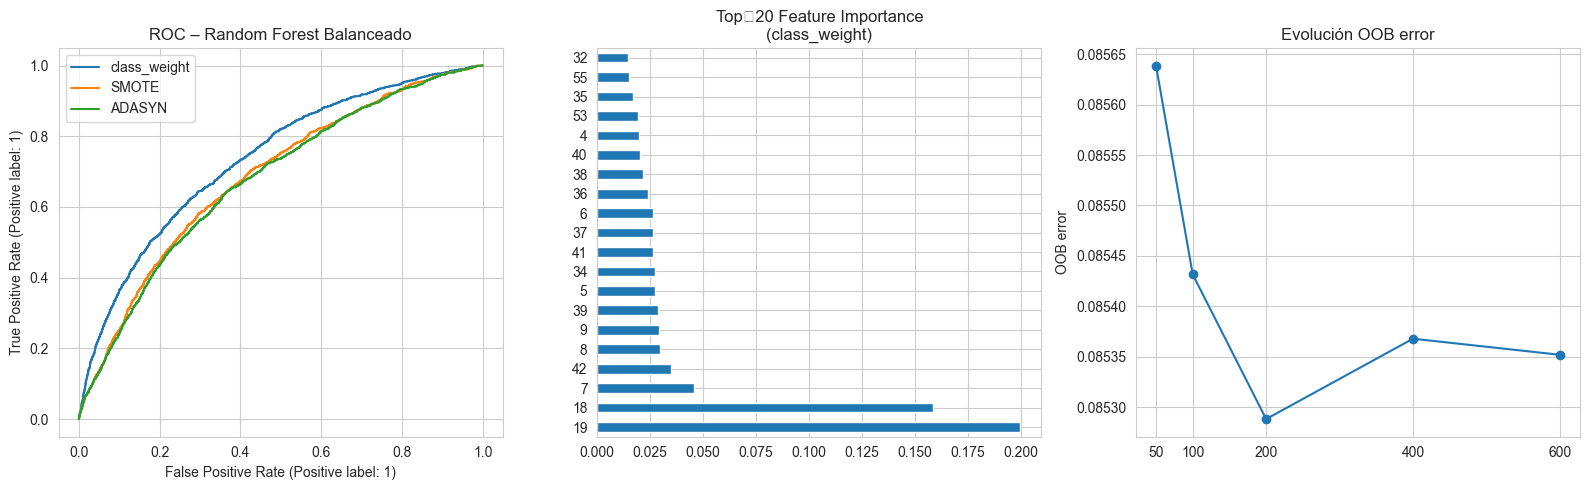

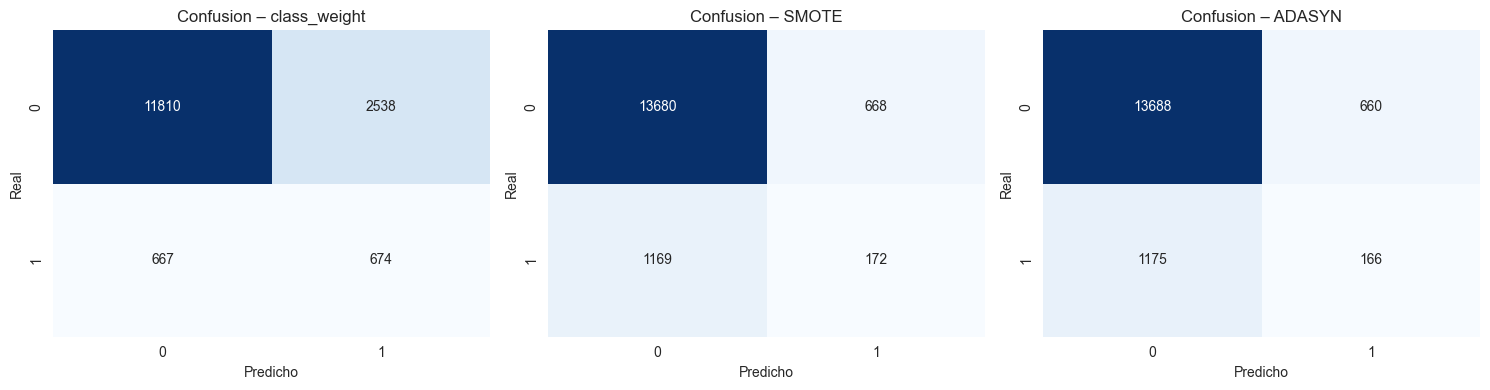

In [9]:
# 9. Gráficas comparativas -----------------------------------------------
plt.figure(figsize=(16,5))

# --- 9.1 Curvas ROC ------------------------------------------------------
plt.subplot(1,3,1)
for name, d in results.items():
    RocCurveDisplay.from_predictions(
        y_test, d["y_prob"], ax=plt.gca(), label=name   # ← label en vez de name
    )
plt.title("ROC – Random Forest Balanceado")
plt.legend()

# --- 9.2 Importancia de variables ---------------------------------------
best_name = df_metrics["AUC"].idxmax()
best_pipe = results[best_name]["estimator"]
best_est  = best_pipe.named_steps["clf"]

importances = pd.Series(best_est.feature_importances_)
importances.nlargest(20).plot(kind="barh", ax=plt.subplot(1,3,2))
plt.title(f"Top‑20 Feature Importance\n({best_name})")
plt.tight_layout()

# --- 9.3 OOB error vs. nº de árboles ------------------------------------
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

oob_errors = {}
best_pre  = best_pipe.named_steps["pre"]        # ya está *fitted*
Xtr_pre   = best_pre.transform(X_train)         # SOLO X, sin y

# Filtrar claves conflictivas
rf_params_limpios = {
    k: v for k, v in rf_params.items() if k not in ['n_estimators', 'oob_score']
}

for n in [50, 100, 200, 400, 600]:
    rf_tmp = RandomForestClassifier(**rf_params_limpios, n_estimators=n, oob_score=True)
    rf_tmp.fit(Xtr_pre, y_train)
    oob_errors[n] = 1 - rf_tmp.oob_score_

# Graficar
pd.Series(oob_errors).plot(marker="o", ax=plt.subplot(1,3,3))
plt.ylabel("OOB error")
plt.title("Evolución OOB error")
plt.xticks(list(oob_errors.keys()))
plt.tight_layout()
plt.show()


# --- 9.4 Matrices de confusión ------------------------------------------
fig, axes = plt.subplots(1,3, figsize=(15,4))
for ax, (name, d) in zip(axes, results.items()):
    cm = confusion_matrix(y_test, d["y_pred"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f"Confusion – {name}")
    ax.set_xlabel("Predicho"); ax.set_ylabel("Real")
plt.tight_layout()
plt.show()


In [10]:

# =====================================================
# 10. Guardar pipeline final (opcional) ----------------
# =====================================================
import joblib
joblib.dump(results[best_name]["estimator"], f"rf_final_{best_name}.pkl")
print(f"Guardado: rf_final_{best_name}.pkl")


Guardado: rf_final_class_weight.pkl
